<a href="https://colab.research.google.com/github/envirodatascience/final-project-env617_personalcareproducts/blob/main/ENV_617_Final_Project_PersonalCareProducts_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install necessary modules
! pip install fiona shapely pyproj rtree --q # need to install geopandas dependencies (geopandas will not auto install dependencies with pip)
! pip install geopandas --q # geopandas/
! pip install plotnine --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Basics
import pandas as pd
import numpy as np

# geo
import geopandas as gpd
from shapely.geometry import Polygon

# Plotnine
from plotnine import *
import plotnine


DATASET - Chemicals Health Risks data from Proposition 65 List in the California Office of Environmental Health Hazard Assessment 

In [3]:
#import "Chemicals health risks" data from the Proposition 65 List in the California Office of Environmental Health Hazard Assessment
url_3 = 'https://raw.githubusercontent.com/envirodatascience/final-project-env617_personalcareproducts/main/Chemicals_Health_Risks.csv'
df_chemicals_risks = pd.read_csv(url_3)
df_chemicals_risks

,Chemical,Type of Toxicity,CAS No.
0,"A-alpha-C (2-Amino-9H-pyrido[2,3-b]indole)",cancer,26148-68-5
1,Abiraterone acetate,"developmental, female, male",154229-18-2
2,Acetaldehyde,cancer,75-07-0
3,Acetamide,cancer,60-35-5
4,Acetazolamide,developmental,59-66-5
...,...,...,...
994,"2,6-Xylidine (2,6-Dimethylaniline)",cancer,87-62-7
995,Zalcitabine,cancer,7481-89-2
996,Zidovudine (AZT),cancer,30516-87-1
997,Zileuton,"cancer, developmental, female",111406-87-2


In [4]:
df_chemicals_risks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Chemical          998 non-null    object
 1   Type of Toxicity  973 non-null    object
 2   CAS No.           972 non-null    object
dtypes: object(3)
memory usage: 23.5+ KB


In [5]:
#Data Wrangling: String Manipulation
#Replace all "/" with "-" in the "CAS No." column
df_chemicals_risks['CAS No.'] = df_chemicals_risks['CAS No.'].str.replace("/", "-")
df_chemicals_risks.head()

,Chemical,Type of Toxicity,CAS No.
0,"A-alpha-C (2-Amino-9H-pyrido[2,3-b]indole)",cancer,26148-68-5
1,Abiraterone acetate,"developmental, female, male",154229-18-2
2,Acetaldehyde,cancer,75-07-0
3,Acetamide,cancer,60-35-5
4,Acetazolamide,developmental,59-66-5


In [6]:
df_chemicals_risks["Type of Toxicity"] = df_chemicals_risks["Type of Toxicity"].str.strip()

In [7]:
df_chemicals_risks["Type of Toxicity"].unique()

array(['cancer', 'developmental, female, male', 'developmental',
       'developmental, male', 'developmental, female', 'female, male',
       nan, 'female', 'male', 'cancer, developmental, female, male',
       'developmental,   male', 'cancer, developmental',
       'cancer, developmental, male', 'developmental male',
       'cancer, developmental, female'], dtype=object)

In [8]:
#df_chemicals_risks['cancer_flag'] = df_chemicals_risks['Type of Toxicity'].apply(lambda x: 1 if 'cancer|cancer, developmental, female, male|cancer, developmental|cancer, developmental|cancer, developmental, male|cancer, developmental, female' in x else 0)

#Splitting up the different type of toxicity into different columns
df_chemicals_risks[['Risk_1', 'Risk_2', 'Risk_3', 'Risk_4']] = df_chemicals_risks['Type of Toxicity'].str.split(',', expand=True)

# drop the original 'Type of Toxicity' column
df_chemicals_risks = df_chemicals_risks.drop('Type of Toxicity', axis=1)

df_chemicals_risks

,Chemical,CAS No.,Risk_1,Risk_2,Risk_3,Risk_4
0,"A-alpha-C (2-Amino-9H-pyrido[2,3-b]indole)",26148-68-5,cancer,None,None,None
1,Abiraterone acetate,154229-18-2,developmental,female,male,None
2,Acetaldehyde,75-07-0,cancer,None,None,None
3,Acetamide,60-35-5,cancer,None,None,None
4,Acetazolamide,59-66-5,developmental,None,None,None
...,...,...,...,...,...,...
994,"2,6-Xylidine (2,6-Dimethylaniline)",87-62-7,cancer,None,None,None
995,Zalcitabine,7481-89-2,cancer,None,None,None
996,Zidovudine (AZT),30516-87-1,cancer,None,None,None
997,Zileuton,111406-87-2,cancer,developmental,female,None


In [9]:
#Creating bnary flags for the 4 health risks
search_string_cancer = 'cancer'
search_string_developmental = 'developmental'
search_string_female = 'female'
search_string_male = 'male'

# create a new column with binary flag
df_chemicals_risks['cancer'] = df_chemicals_risks.apply(lambda x: 1 if (search_string_cancer in [x['Risk_1'], x['Risk_2'], x['Risk_3'], x['Risk_4']]) else 0, axis=1)
df_chemicals_risks['developmental'] = df_chemicals_risks.apply(lambda x: 1 if (search_string_developmental in [x['Risk_1'], x['Risk_2'], x['Risk_3'], x['Risk_4']]) else 0, axis=1)
df_chemicals_risks['female'] = df_chemicals_risks.apply(lambda x: 1 if (search_string_female in [x['Risk_1'], x['Risk_2'], x['Risk_3'], x['Risk_4']]) else 0, axis=1)
df_chemicals_risks['male'] = df_chemicals_risks.apply(lambda x: 1 if (search_string_male in [x['Risk_1'], x['Risk_2'], x['Risk_3'], x['Risk_4']]) else 0, axis=1)
df_chemicals_risks.head()

,Chemical,CAS No.,Risk_1,Risk_2,Risk_3,Risk_4,cancer,developmental,female,male
0,"A-alpha-C (2-Amino-9H-pyrido[2,3-b]indole)",26148-68-5,cancer,None,None,None,1,0,0,0
1,Abiraterone acetate,154229-18-2,developmental,female,male,None,0,1,0,0
2,Acetaldehyde,75-07-0,cancer,None,None,None,1,0,0,0
3,Acetamide,60-35-5,cancer,None,None,None,1,0,0,0
4,Acetazolamide,59-66-5,developmental,None,None,None,0,1,0,0


DATASET - Chemicals in cosmetics" data from the California Safe Cosmetics Program (CSCP) in the California Department of Public Health 

In [10]:
#import "Chemicals in cosmetics" data from the California Safe Cosmetics Program (CSCP) in the California Department of Public Health
url_2 = 'https://data.chhs.ca.gov/dataset/596b5eed-31de-4fd8-a645-249f3f9b19c4/resource/57da6c9a-41a7-44b0-ab8d-815ff2cd5913/download/cscpopendata.csv'
data = pd.read_csv(url_2)
df_chemicals_1 = pd.DataFrame(data)
df_chemicals_1

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,13463-67-7,6,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1
1,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,65996-92-1,4,Distillates (coal tar),07/01/2009,07/01/2009,NaN,07/01/2009,07/01/2009,NaN,2
2,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,140-67-0,5,Estragole,07/01/2009,07/01/2009,NaN,07/02/2009,07/02/2009,NaN,2
3,4,PRECISION GLIMMER EYE LINER-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,...,13463-67-7,7,Titanium dioxide,07/09/2009,08/28/2013,NaN,07/09/2009,07/09/2009,NaN,1
4,5,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,...,13463-67-7,8,Titanium dioxide,07/09/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114630,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65001.0,Rosa Soft,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,13463-67-7,68059,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1
114631,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65002.0,Malva Spirit,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,13463-67-7,68060,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1
114632,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65003.0,Rojo Fashion,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,13463-67-7,68061,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1
114633,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65004.0,Terra Mystic,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,13463-67-7,68062,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1


In [11]:
#Cast primary category column from object to string
df_chemicals_1['PrimaryCategory']=df_chemicals_1['PrimaryCategory'].astype(str)

In [12]:
##Create 'Segment' column to align PrimaryCategory with data that divides the beauty and personal care market into 4 segments
conditions = [
    (df_chemicals_1.PrimaryCategory == 'Makeup Products (non-permanent)') | (df_chemicals_1.PrimaryCategory == 'Nail Products'),
    (df_chemicals_1.PrimaryCategory == 'Baby Products') | (df_chemicals_1.PrimaryCategory == 'Skin Care Products') | (df_chemicals_1.PrimaryCategory == 'Sun-Related Products'),
    (df_chemicals_1.PrimaryCategory == 'Bath Products') | (df_chemicals_1.PrimaryCategory == 'Hair Care Products (non-coloring)') | (df_chemicals_1.PrimaryCategory == 'Hair Coloring Products') | (df_chemicals_1.PrimaryCategory == 'Oral Hygiene Products') | (df_chemicals_1.PrimaryCategory == 'Personal Care Products') | (df_chemicals_1.PrimaryCategory == 'Shaving Products'),
    (df_chemicals_1.PrimaryCategory == 'Fragrances')
    ]

values = ['Cosmetics', 'Skin Care', 'Personal Care', 'Fragrances']

df_chemicals_1['Segment'] = np.select(conditions, values)
df_chemicals_1

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount,Segment
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,6,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1,Cosmetics
1,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,4,Distillates (coal tar),07/01/2009,07/01/2009,NaN,07/01/2009,07/01/2009,NaN,2,Personal Care
2,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,5,Estragole,07/01/2009,07/01/2009,NaN,07/02/2009,07/02/2009,NaN,2,Personal Care
3,4,PRECISION GLIMMER EYE LINER-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,...,7,Titanium dioxide,07/09/2009,08/28/2013,NaN,07/09/2009,07/09/2009,NaN,1,Cosmetics
4,5,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,...,8,Titanium dioxide,07/09/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1,Cosmetics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114630,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65001.0,Rosa Soft,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68059,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics
114631,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65002.0,Malva Spirit,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68060,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics
114632,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65003.0,Rojo Fashion,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68061,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics
114633,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65004.0,Terra Mystic,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68062,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics


In [13]:
#drop rows that have a '0' (i.e. unidentified) segment
#The rows with '0' in segment are those originally assigned to Tattoos and Permanent Makeup (not included in analysis)
df_chemicals_1.drop(df_chemicals_1.loc[df_chemicals_1['Segment']=='0'].index, inplace=True)
df_chemicals_1

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount,Segment
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,6,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1,Cosmetics
1,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,4,Distillates (coal tar),07/01/2009,07/01/2009,NaN,07/01/2009,07/01/2009,NaN,2,Personal Care
2,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,5,Estragole,07/01/2009,07/01/2009,NaN,07/02/2009,07/02/2009,NaN,2,Personal Care
3,4,PRECISION GLIMMER EYE LINER-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,...,7,Titanium dioxide,07/09/2009,08/28/2013,NaN,07/09/2009,07/09/2009,NaN,1,Cosmetics
4,5,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,...,8,Titanium dioxide,07/09/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1,Cosmetics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114630,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65001.0,Rosa Soft,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68059,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics
114631,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65002.0,Malva Spirit,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68060,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics
114632,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65003.0,Rojo Fashion,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68061,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics
114633,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65004.0,Terra Mystic,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68062,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics


In [14]:
#Join df_chemicals with df_chemicals_risks
df_chemicals_risks_merge = pd.merge(df_chemicals_1, df_chemicals_risks, left_on='CasNumber', right_on='CAS No.')
df_chemicals_risks_merge

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,Chemical,CAS No.,Risk_1,Risk_2,Risk_3,Risk_4,cancer,developmental,female,male
0,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,Estragole,140-67-0,cancer,None,None,None,1,0,0,0
1,862,Best of Skintentions,NaN,NaN,18,Bliss World LLC,Bliss,106,Sun-Related Products,107,...,Estragole,140-67-0,cancer,None,None,None,1,0,0,0
2,1692,Pore-Perfecting Facial Polish,NaN,NaN,18,Bliss World LLC,Bliss,6,Bath Products,166,...,Estragole,140-67-0,cancer,None,None,None,1,0,0,0
3,1728,Soft Focusing Lotion,NaN,NaN,18,Bliss World LLC,Laboratoire Remede,44,Makeup Products (non-permanent),50,...,Estragole,140-67-0,cancer,None,None,None,1,0,0,0
4,3109,Country Peach Body and Hair Shampoo,NaN,NaN,973,Henkel Corporation,Dial,6,Bath Products,159,...,Estragole,140-67-0,cancer,None,None,None,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157459,37068,Tom's of Maine Natural Fluoride Free SLS free ...,NaN,NaN,561,"Tom's of Maine, Inc.",Tom's of Maine,68,Oral Hygiene Products,69,...,Polygeenan,53973-98-1,cancer,None,None,None,1,0,0,0
157460,37068,Tom's of Maine Natural Fluoride Free SLS free ...,NaN,NaN,561,"Tom's of Maine, Inc.",Tom's of Maine,68,Oral Hygiene Products,69,...,Polygeenan,53973-98-1,cancer,None,None,None,1,0,0,0
157461,37068,Tom's of Maine Natural Fluoride Free SLS free ...,NaN,NaN,561,"Tom's of Maine, Inc.",Tom's of Maine,68,Oral Hygiene Products,167,...,Polygeenan,53973-98-1,cancer,None,None,None,1,0,0,0
157462,37068,Tom's of Maine Natural Fluoride Free SLS free ...,NaN,NaN,561,"Tom's of Maine, Inc.",Tom's of Maine,68,Oral Hygiene Products,167,...,Polygeenan,53973-98-1,cancer,None,None,None,1,0,0,0


In [15]:
df_chemicals_risks_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157464 entries, 0 to 157463
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CDPHId                  157464 non-null  int64  
 1   ProductName             157464 non-null  object 
 2   CSFId                   93937 non-null   float64
 3   CSF                     90967 non-null   object 
 4   CompanyId               157464 non-null  int64  
 5   CompanyName             157464 non-null  object 
 6   BrandName               157437 non-null  object 
 7   PrimaryCategoryId       157464 non-null  int64  
 8   PrimaryCategory         157464 non-null  object 
 9   SubCategoryId           157464 non-null  int64  
 10  SubCategory             157464 non-null  object 
 11  CasId                   157464 non-null  int64  
 12  CasNumber               4887 non-null    object 
 13  ChemicalId              157464 non-null  int64  
 14  ChemicalName        

In [49]:
#Which primary category of personal care product cosnsits of the highest number of chemicals with cancer and developmental risk
df_prim_category_chemicals_risks = df_chemicals_risks_merge.groupby('PrimaryCategory', as_index=False).agg(n_cancer=('cancer','sum'),n_developmental=('developmental','sum'))
df_prim_category_chemicals_risks.reset_index()

,index,PrimaryCategory,n_cancer,n_developmental
0,0,Baby Products,6,13
1,1,Bath Products,120,346
2,2,Fragrances,137,58
3,3,Hair Care Products (non-coloring),245,290
4,4,Hair Coloring Products,67,14
5,5,Makeup Products (non-permanent),2686,3538
6,6,Nail Products,1056,1088
7,7,Oral Hygiene Products,5,48
8,8,Personal Care Products,84,207
9,9,Shaving Products,42,30


In [50]:
#Which segment has the highest number of chemicals with cancer and developmental risk
df_segment_chemicals_risks = df_chemicals_risks_merge.groupby('Segment', as_index=False).agg(n_cancer=('cancer','sum'),n_developmental=('developmental','sum'))
df_segment_chemicals_risks.reset_index()

,index,Segment,n_cancer,n_developmental
0,0,Cosmetics,3742,4626
1,1,Fragrances,137,58
2,2,Personal Care,563,935
3,3,Skin Care,91,245


In [18]:
#Create new dataframe with just Cosmetics segment
df_chemicals_cosmetics = df_chemicals_1.loc[df_chemicals_1['Segment'] == 'Cosmetics']
df_chemicals_cosmetics


,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount,Segment
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,6,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1,Cosmetics
3,4,PRECISION GLIMMER EYE LINER-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,...,7,Titanium dioxide,07/09/2009,08/28/2013,NaN,07/09/2009,07/09/2009,NaN,1,Cosmetics
4,5,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,...,8,Titanium dioxide,07/09/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1,Cosmetics
5,6,JILLIAN DEMPSEY FOR AVON CELESTIAL EYESHADOW-A...,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),48,...,9,Titanium dioxide,07/09/2009,08/28/2013,11/01/2010,07/09/2009,07/09/2009,NaN,1,Cosmetics
6,7,ABSOLUTE Precision Color Powder System - All S...,310.0,5858-81-1,11,OPI PRODUCTS INC.,OPI,59,Nail Products,60,...,12178,Titanium dioxide,07/13/2009,12/30/2010,NaN,12/04/2009,12/04/2009,NaN,1,Cosmetics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114629,41522,EYESHADOW / ATARDECER NARANJA,65000.0,Crema T1,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),48,...,68058,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics
114630,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65001.0,Rosa Soft,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68059,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics
114631,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65002.0,Malva Spirit,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68060,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics
114632,41523,HYDRA-LIP TRANSLUCENT COLOR LIPSTICK,65003.0,Rojo Fashion,1259,"Yanbal USA, Inc",YANBAL,44,Makeup Products (non-permanent),53,...,68061,Titanium dioxide,06/19/2020,06/19/2020,NaN,06/19/2020,06/19/2020,NaN,1,Cosmetics


In [19]:
#Join df_chemicals_cosmetics with df_chemicals_risks
df_chemicals_cosmetics_risks_merge = pd.merge(df_chemicals_cosmetics, df_chemicals_risks, left_on='CasNumber', right_on='CAS No.')
df_chemicals_cosmetics_risks_merge

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,Chemical,CAS No.,Risk_1,Risk_2,Risk_3,Risk_4,cancer,developmental,female,male
0,37,UV Nail Topcoat,NaN,NaN,33,"Entity Beauty, Inc.",Entity Nail Top Coat,59,Nail Products,168,...,Toluene,108-88-3,developmental,None,None,None,0,1,0,0
1,37,UV Nail Topcoat,NaN,NaN,33,"Entity Beauty, Inc.",Entity Nail Top Coat,59,Nail Products,168,...,Toluene [Click here for the basis for the remo...,108-88-3,female,None,None,None,0,0,1,0
2,1153,OPI Lacquer,NaN,NaN,110,"Alfalfa Nail Supply, Inc.",OPI,59,Nail Products,65,...,Toluene,108-88-3,developmental,None,None,None,0,1,0,0
3,1153,OPI Lacquer,NaN,NaN,110,"Alfalfa Nail Supply, Inc.",OPI,59,Nail Products,65,...,Toluene [Click here for the basis for the remo...,108-88-3,female,None,None,None,0,0,1,0
4,1155,Sation Lacquer,NaN,NaN,110,"Alfalfa Nail Supply, Inc.",Sation,59,Nail Products,65,...,Toluene,108-88-3,developmental,None,None,None,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125328,38791,Attraction Nail Liquid,NaN,NaN,82,AMCO International,NSI,59,Nail Products,60,...,"N,N-Dimethyl-p-toluidine",99-97-8,cancer,None,None,None,1,0,0,0
125329,38796,Universal Liquid,NaN,NaN,82,AMCO International,NSI,59,Nail Products,60,...,"N,N-Dimethyl-p-toluidine",99-97-8,cancer,None,None,None,1,0,0,0
125330,38797,Spa Nail Liquid,NaN,NaN,82,AMCO International,NSI,59,Nail Products,60,...,"N,N-Dimethyl-p-toluidine",99-97-8,cancer,None,None,None,1,0,0,0
125331,38798,Secrets Artiste Nail Liquid,NaN,NaN,82,AMCO International,NSI,59,Nail Products,60,...,"N,N-Dimethyl-p-toluidine",99-97-8,cancer,None,None,None,1,0,0,0


In [20]:
df_chemicals_cosmetics_risks_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125333 entries, 0 to 125332
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CDPHId                  125333 non-null  int64  
 1   ProductName             125333 non-null  object 
 2   CSFId                   84484 non-null   float64
 3   CSF                     81514 non-null   object 
 4   CompanyId               125333 non-null  int64  
 5   CompanyName             125333 non-null  object 
 6   BrandName               125333 non-null  object 
 7   PrimaryCategoryId       125333 non-null  int64  
 8   PrimaryCategory         125333 non-null  object 
 9   SubCategoryId           125333 non-null  int64  
 10  SubCategory             125333 non-null  object 
 11  CasId                   125333 non-null  int64  
 12  CasNumber               3968 non-null    object 
 13  ChemicalId              125333 non-null  int64  
 14  ChemicalName        

In [21]:
df_chemicals_cosmetics_risks_merge[['ProductName', 'CompanyName', 'PrimaryCategory']].nunique()

ProductName        2771
CompanyName         148
PrimaryCategory       2
dtype: int64

In [22]:
#Which primary category in cosmetics has the highest cancer and developmental risk
df_chemicals_cosmetics_risks_merge.groupby('PrimaryCategory').agg(n_cancer=('cancer','sum'),n_developmental=('developmental','sum'))

,n_cancer,n_developmental
PrimaryCategory,,
Makeup Products (non-permanent),2686,3538
Nail Products,1056,1088


In [23]:
df_chemicals_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105475 entries, 0 to 114634
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CDPHId                  105475 non-null  int64  
 1   ProductName             105475 non-null  object 
 2   CSFId                   77659 non-null   float64
 3   CSF                     77237 non-null   object 
 4   CompanyId               105475 non-null  int64  
 5   CompanyName             105475 non-null  object 
 6   BrandName               105325 non-null  object 
 7   PrimaryCategoryId       105475 non-null  int64  
 8   PrimaryCategory         105475 non-null  object 
 9   SubCategoryId           105475 non-null  int64  
 10  SubCategory             105475 non-null  object 
 11  CasId                   105475 non-null  int64  
 12  CasNumber               99824 non-null   object 
 13  ChemicalId              105475 non-null  int64  
 14  ChemicalName        

In [24]:
#What are the unique values in ProductName
df_chemicals_1['ProductName'].unique()

array(['ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES',
       "Glover's Medicated Shampoo",
       'PRECISION GLIMMER EYE LINER-ALL SHADES �', ...,
       'EYESHADOW  / ATARDECER NARANJA',
       'HYDRA-LIP TRANSLUCENT COLOR LIPSTICK',
       'OLD SPICE GENTLEMENS BLEND ALOE AND WILD SAGE BAR SOAP'],
      dtype=object)

In [25]:
#Number of unique values in ProductName
df_chemicals_1['ProductName'].nunique()

29367

In [26]:
#What are the unique values in CompanyName
df_chemicals_1['CompanyName'].unique()

array(['New Avon LLC', 'J. Strickland & Co.', 'OPI PRODUCTS INC.',
       'GOJO Industries, Inc.', 'CHANEL, INC',
       'Aloecare International, LLC', 'Entity Beauty, Inc.',
       'Revlon Consumer Product Corporation', 'Dermalogica',
       'CLARINS S.A.', 'McConnell Labs, Inc.', 'Philosophy',
       "L'Oreal USA", 'Elizabeth Arden, Inc.',
       'Sunrider Manufacturing, L.P.', 'AMCO International',
       'Buth-na-Bodhaige, Inc', 'The Procter & Gamble Company',
       'Bare Escentuals Beauty, Inc.', 'Regis Corporation',
       'Bliss World LLC', 'Merle Norman Cosmetics',
       'Zotos International, Inc.', 'Arcadia Beauty Labs LLC',
       'TIGI Linea Corp', 'Colomer U.S.A., Inc.',
       'Alfalfa Nail Supply, Inc.', 'No Lift Nails Inc.',
       'NeoStrata Company, Inc.', 'BeautiControl, Inc.',
       'Klein-Becker USA, LLC.', 'C.F.E.B. SISLEY', 'Whiter Image',
       'NOEVIR CO., LTD', 'Young Nails, Inc.', 'Beiersdorf, Inc.',
       'Added Extras LLC', 'Giovanni Cosmetics, Inc.',
 

In [27]:
#Number of unique values in CompanyName
df_chemicals_1['CompanyName'].nunique()

536

In [28]:
#What are the unique values in Segment
df_chemicals_1['Segment'].unique()

array(['Cosmetics', 'Personal Care', 'Skin Care', 'Fragrances'],
      dtype=object)

In [29]:
#Number of unique values in Segment
df_chemicals_1['Segment'].nunique()

4

In [30]:
#What are the unique values in Segment
df_chemicals_1['SubCategory'].unique()

array(['Lip Color - Lipsticks, Liners, and Pencils',
       'Hair Shampoos (making a cosmetic claim) ',
       'Eyeliner/Eyebrow Pencils', 'Lip Gloss/Shine', 'Eye Shadow',
       'Artificial Nails and Related Products',
       'Mascara/Eyelash Products', 'Hand Cleansers and Sanitizers',
       'Sunscreen (making a cosmetic claim) ', 'UV Gel Nail Polish',
       'Basecoats and Undercoats', 'Scrubs and Exfoliants',
       'Foundations and Bases', 'Nail Polish and Enamel',
       'Lip Balm (making a cosmetic claim)',
       'Perfumes - Solids and Powders', 'Blushes ',
       'Bubble and Foam Bath Products', 'Body Washes and Soaps', 'Rouges',
       'Face Powders', 'Hair Styling Products', 'Other Nail Products ',
       'Indoor Tanning Products', 'Other Makeup Product',
       'Hair Dyes and Colors', 'Teeth Cleaning Products',
       'Nail Polish and Enamel Removers', 'Makeup Fixatives',
       'Perfumes - Oils and Lotions', 'Hair Conditioners (rinse-out)',
       'Shaving Cream and other 

In [31]:
#What are the unique values in ChemicalName
df_chemicals_1['ChemicalName'].unique()

array(['Titanium dioxide', 'Distillates (coal tar)', 'Estragole',
       'Cocamide diethanolamine', 'Toluene',
       'Chromium (hexavalent compounds)',
       'Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.',
       'Coffea arabica extract', 'Lauramide diethanolamine', 'Coffee',
       'Silica, crystalline (airborne particles of respirable size)',
       'Carbon black',
       '2,4-Hexadienal (89% trans, trans isomer; 11% cis, trans isomer)',
       'Methyleugenol', 'Carbon-black extracts', 'Retinyl palmitate',
       'o-Phenylphenol', 'Acrylamide', 'Formaldehyde (gas)',
       'Ginkgo biloba extract', 'Butylated hydroxyanisole', 'Mica',
       'Vitamin A',
       'Carbon black (airborne, unbound particles of respirable size)',
       'Vitamin A palmitate', 'Ethylene glycol', 'Ethyl acrylate',
       'Trade Secret', 'Methanol',
       'Mineral oils, untreated and mildly treated', 'Diethanolamine',
       'TEA-Lauryl Sulfate', 'Retin

In [32]:
#Number of unique values in ChemicalName
df_chemicals_1['ChemicalName'].nunique()

112

In [33]:
 list(df_chemicals_1.columns.values)

['CDPHId',
 'ProductName',
 'CSFId',
 'CSF',
 'CompanyId',
 'CompanyName',
 'BrandName',
 'PrimaryCategoryId',
 'PrimaryCategory',
 'SubCategoryId',
 'SubCategory',
 'CasId',
 'CasNumber',
 'ChemicalId',
 'ChemicalName',
 'InitialDateReported',
 'MostRecentDateReported',
 'DiscontinuedDate',
 'ChemicalCreatedAt',
 'ChemicalUpdatedAt',
 'ChemicalDateRemoved',
 'ChemicalCount',
 'Segment']

In [34]:
df_chemicals_1_cat = df_chemicals_1.groupby('CompanyName').agg(total_category=('Segment','nunique'), total_chemical=('ChemicalName','nunique'))
df_chemicals_1_cat = df_chemicals_1_cat.sort_values('total_category', ascending=False).reset_index()
df_chemicals_1_cat

,CompanyName,total_category,total_chemical
0,"Oceana USA, Inc.",4,5
1,New Avon LLC,4,3
2,Bath & Body Works,4,2
3,Philosophy,4,8
4,"Elizabeth Arden, Inc.",4,10
...,...,...,...
531,"MSD Consumer Care, Inc.",1,1
532,Cosmetic Dermatology Inc,1,1
533,MOMOTANI JUNTENKAN LTD.,1,1
534,MIRAGE COSMETICS INC,1,2


In [35]:
df_chemicals_1_cat2 = df_chemicals_1.groupby('Segment').agg(list_chemical=('ChemicalName','nunique'))
df_chemicals_1_cat2

,list_chemical
Segment,
Cosmetics,60
Fragrances,23
Personal Care,90
Skin Care,43


In [36]:
#for cosmetics
df_chemicals_1_cat5 = df_chemicals_cosmetics.groupby('CompanyName').agg(list_chemical=('ChemicalName','nunique'))
df_chemicals_1_cat5 = df_chemicals_1_cat5.sort_values('list_chemical', ascending=False).reset_index()

#Filter to report only companies with >5 reported ingredients
df_chemicals_1_cat5 = df_chemicals_1_cat5[df_chemicals_1_cat5['list_chemical'] > 5]  
df_chemicals_1_cat5

,CompanyName,list_chemical
0,Palladio Beauty Group,15
1,Coty,13
2,"Ventura International, Ltd",10
3,Fisk Industries Inc,10
4,"Kendo Holdings, Inc.",9
5,American International Industries,8
6,"Rituals Cosmetics USA, Inc.",7
7,S+,7
8,Tarte Cosmetics,7
9,Too Faced Cosmetics,7


In [37]:
#for cosmetics
df_chemicals_1_cat6 = df_chemicals_cosmetics.groupby('SubCategory').agg(list_chemical=('ChemicalName','nunique'))
df_chemicals_1_cat6 = df_chemicals_1_cat6.sort_values('list_chemical', ascending=False).reset_index()
df_chemicals_1_cat6

,SubCategory,list_chemical
0,Foundations and Bases,29
1,Eye Shadow,25
2,Eyeliner/Eyebrow Pencils,24
3,"Lip Color - Lipsticks, Liners, and Pencils",23
4,Lip Balm (making a cosmetic claim),22
5,Lip Gloss/Shine,22
6,Other Makeup Product,22
7,Blushes,21
8,Face Powders,21
9,Nail Polish and Enamel,20


In [38]:
df_chemicals_1_cat3 = df_chemicals_1.groupby('ChemicalName').agg(list_category=('Segment','unique'))
df_chemicals_1_cat3

,list_category
ChemicalName,
"1,4-Dioxane",[Personal Care]
"2,4-Hexadienal (89% trans, trans isomer; 11% cis, trans isomer)","[Skin Care, Fragrances]"
2-Propyleneacrolein,[Cosmetics]
Acetaldehyde,"[Personal Care, Fragrances, Cosmetics, Skin Care]"
Acetylsalicylic acid,[Personal Care]
...,...
Vitamin A palmitate,"[Cosmetics, Skin Care, Personal Care, Fragrances]"
beta-Myrcene,"[Personal Care, Skin Care, Cosmetics, Fragrances]"
o-Phenylenediamine and its salts,[Personal Care]


In [39]:
df_chemicals_1_cat4 = df_chemicals_1.groupby('Segment').agg(list_Company=('CompanyName','nunique'))
df_chemicals_1_cat4 = df_chemicals_1_cat4.sort_values('list_Company', ascending=False).reset_index()
df_chemicals_1_cat4

,Segment,list_Company
0,Personal Care,324
1,Cosmetics,292
2,Skin Care,183
3,Fragrances,43


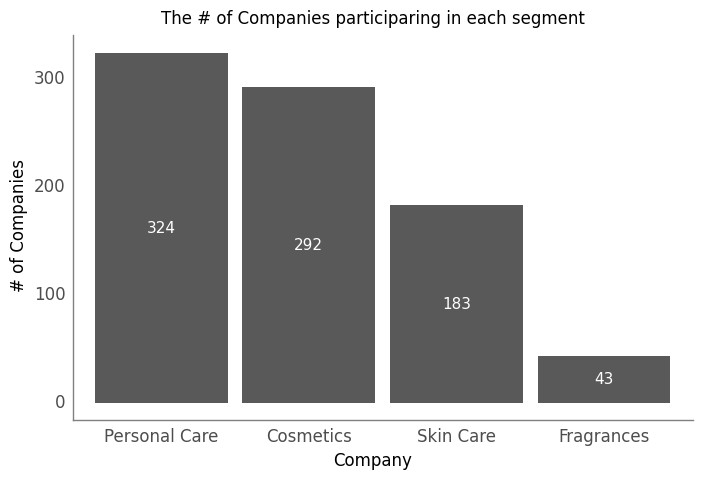

<ggplot: (8769717216687)>

In [40]:
#bar chart - # of Companies per Segment

plotnine.options.figure_size =(8,5)

Segment_list = df_chemicals_1_cat4['Segment'].tolist()

p =(
    ggplot(df_chemicals_1_cat4,aes(x='Segment',y='list_Company', label='list_Company')) # labels argument puts data labels on bars
      + geom_bar(stat='identity') # arranges aes() maps into bar geometry. stat='identity' means use the y aes for the
      + geom_text(position=position_stack(vjust=.5),color='white') # adjusts the positioning and color of the data lab
      + scale_x_discrete(limits=Segment_list) # orders the categorical data in the order of thelist
      + xlab("Company") # adds x axis label
      + ylab("# of Companies") # adds y axis label
      + ggtitle("The # of Companies participaring in each segment") # adds chart title
      + theme_classic() # predefined 'look and feel' format. theme_classic () is very simple. See for more: https://plot
      + theme(axis_line=element_line(color="gray"), # further adjusts theme_classic() - axis line white 
              axis_ticks=element_line (color ="white"), # further adjusts theme_classic() - axis ticks white
              text=element_text(size = 12))
  )

p

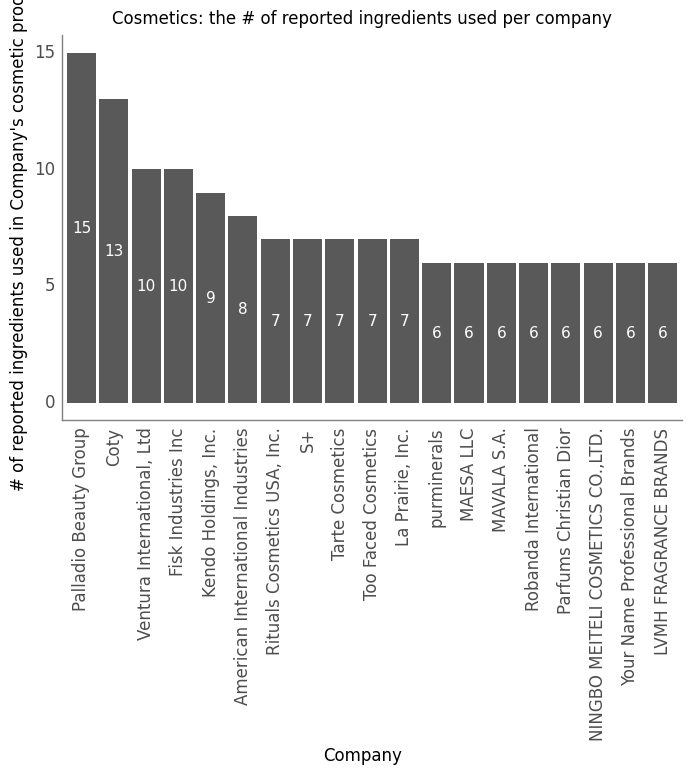

<ggplot: (8769716590571)>

In [41]:
#bar chart - Cosmetics: # of reported ingredients used per company

plotnine.options.figure_size =(8,5)

Company_list = df_chemicals_1_cat5['CompanyName'].tolist()

q =(
    ggplot(df_chemicals_1_cat5,aes(x='CompanyName',y='list_chemical', label='list_chemical')) # labels argument puts data labels on bars
      + geom_bar(stat='identity') # arranges aes() maps into bar geometry. stat='identity' means use the y aes for the
      + geom_text(position=position_stack(vjust=.5),color='white') # adjusts the positioning and color of the data lab
      + scale_x_discrete(limits=Company_list) # orders the categorical data in the order of thelist
      + xlab("Company") # adds x axis label
      + ylab("# of reported ingredients used in Company's cosmetic products") # adds y axis label
      + ggtitle("Cosmetics: the # of reported ingredients used per company") # adds chart title
      + theme_classic() # predefined 'look and feel' format. theme_classic () is very simple. See for more: https://plot
      + theme(axis_text_x = element_text(angle = 90, vjust = 1, hjust=.5),
              axis_line=element_line(color="gray"), # further adjusts theme_classic() - axis line white 
              axis_ticks=element_line (color ="white"), # further adjusts theme_classic() - axis ticks white
              text=element_text(size = 12))
  )

q

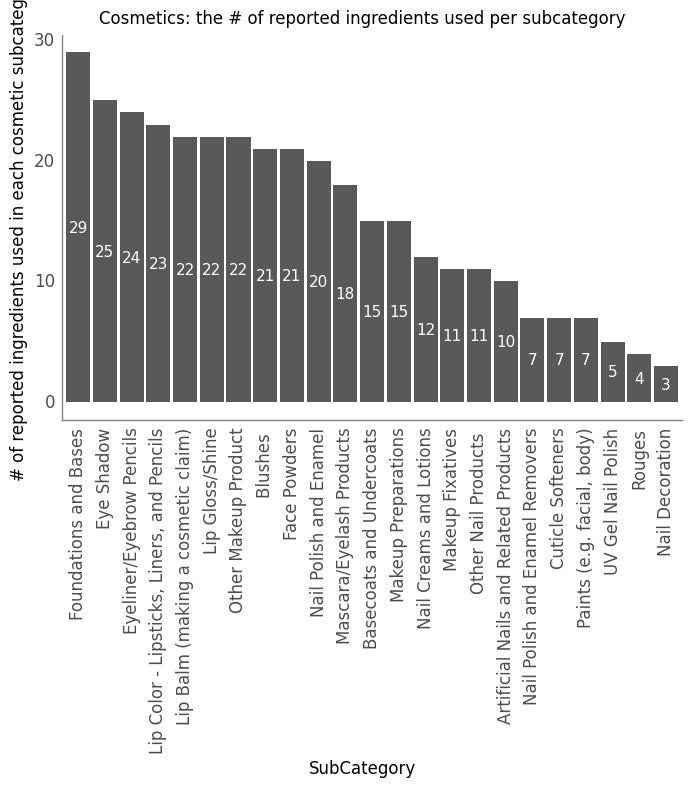

<ggplot: (8769716506347)>

In [42]:
#bar chart - Cosmetics: # of reported ingredients used per subcategory 

plotnine.options.figure_size =(8,5)

Category_list = df_chemicals_1_cat6['SubCategory'].tolist()

k =(
    ggplot(df_chemicals_1_cat6,aes(x='SubCategory',y='list_chemical', label='list_chemical')) # labels argument puts data labels on bars
      + geom_bar(stat='identity') # arranges aes() maps into bar geometry. stat='identity' means use the y aes for the
      + geom_text(position=position_stack(vjust=.5),color='white') # adjusts the positioning and color of the data lab
      + scale_x_discrete(limits=Category_list) # orders the categorical data in the order of thelist
      + xlab("SubCategory") # adds x axis label
      + ylab("# of reported ingredients used in each cosmetic subcategory") # adds y axis label
      + ggtitle("Cosmetics: the # of reported ingredients used per subcategory") # adds chart title
      + theme_classic() # predefined 'look and feel' format. theme_classic () is very simple. See for more: https://plot
      + theme(axis_text_x = element_text(angle = 90, vjust = 1, hjust=.5),
              axis_line=element_line(color="gray"), # further adjusts theme_classic() - axis line white 
              axis_ticks=element_line (color ="white"), # further adjusts theme_classic() - axis ticks white
              text=element_text(size = 12))
  )

k

In [54]:
df_prim_category_chemicals_risks

,PrimaryCategory,n_cancer,n_developmental
0,Baby Products,6,13
1,Bath Products,120,346
2,Fragrances,137,58
3,Hair Care Products (non-coloring),245,290
4,Hair Coloring Products,67,14
5,Makeup Products (non-permanent),2686,3538
6,Nail Products,1056,1088
7,Oral Hygiene Products,5,48
8,Personal Care Products,84,207
9,Shaving Products,42,30


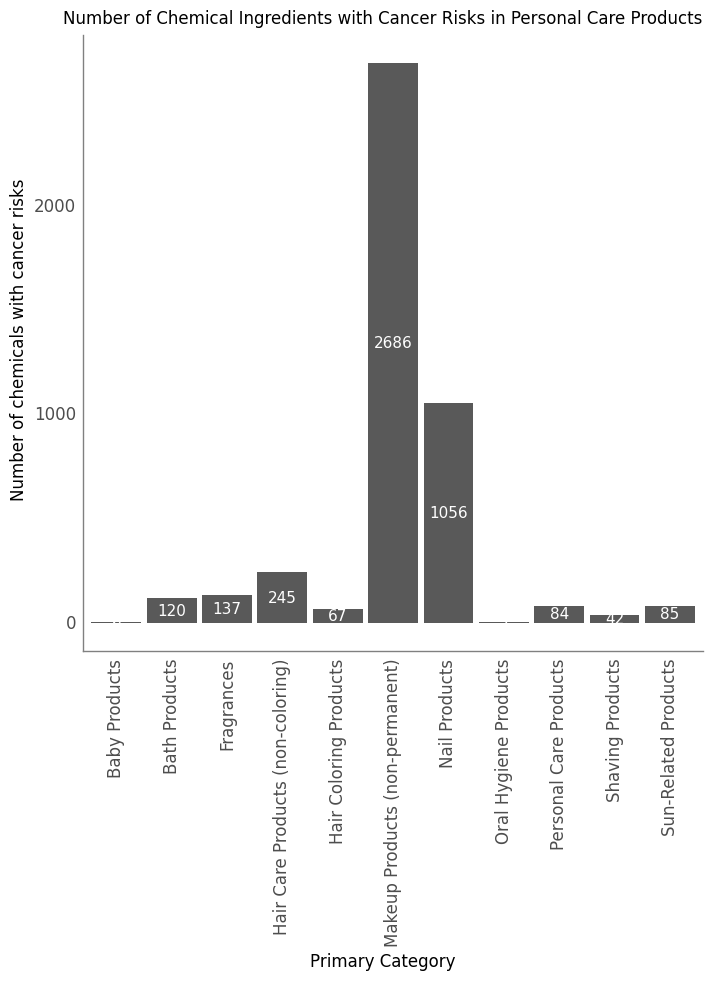

<ggplot: (8769713869180)>

In [67]:
#bar chart - # of reported ingredients with cancer risks per primary category
plotnine.options.figure_size = (8, 8)

p= (
    ggplot(df_prim_category_chemicals_risks, aes(x='PrimaryCategory', y='n_cancer', label='n_cancer')) # labels argument puts data labels on bars 
      + geom_bar(stat='identity') # arranges aes() maps into bar geometry
      + geom_text(position=position_stack(vjust=.5), color='white') # adjusts the positioning and color of the data labels
      + xlab("Primary Category") # adds x axis label
      + ylab("Number of chemicals with cancer risks") # adds y axis label
      + ggtitle("Number of Chemical Ingredients with Cancer Risks in Personal Care Products") # adds chart title
      + theme_classic() # predefined 'look and feel' format. theme_classic() is very simple. See for more: https://plotnine.readthedocs.io/en/stable/api.html#themes
      + theme(axis_text_x = element_text(angle = 90, vjust = 1, hjust=.5),
              axis_line=element_line(color="gray"), # further adjusts theme_classic() - axis line white 
              axis_ticks=element_line (color ="white"), # further adjusts theme_classic() - axis ticks white
              text=element_text(size = 12))
  ) 

p

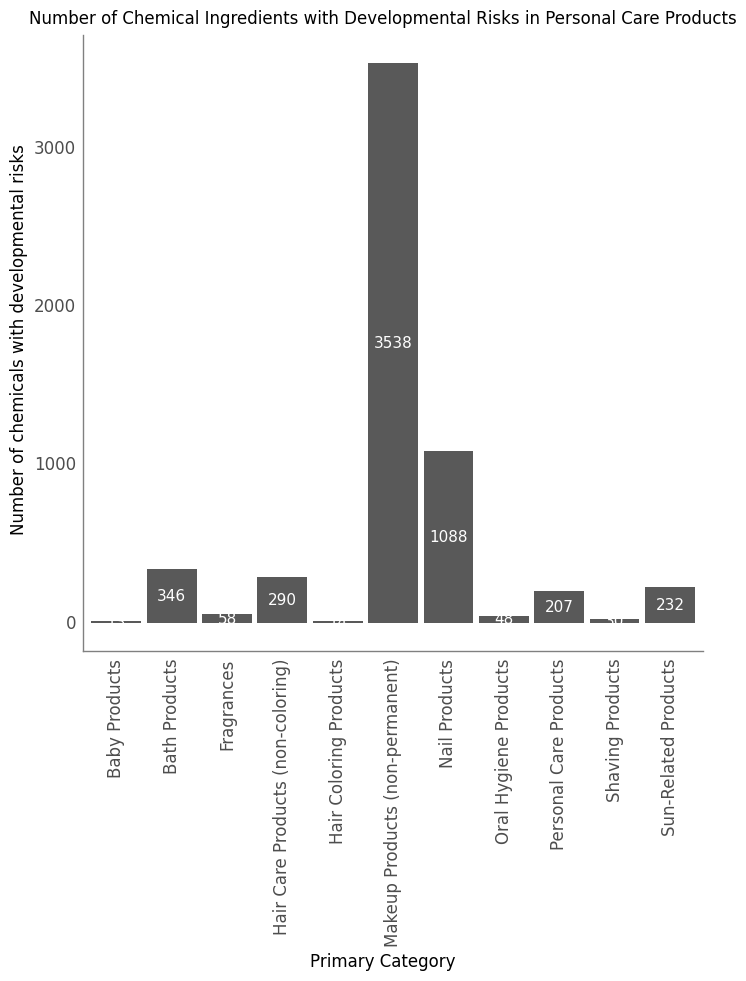

<ggplot: (8769713819296)>

In [68]:
#bar chart - # of reported ingredients with developmental risks per primary category
plotnine.options.figure_size = (8, 8)

p= (
    ggplot(df_prim_category_chemicals_risks, aes(x='PrimaryCategory', y='n_developmental', label='n_developmental')) # labels argument puts data labels on bars 
      + geom_bar(stat='identity') # arranges aes() maps into bar geometry
      + geom_text(position=position_stack(vjust=.5), color='white') # adjusts the positioning and color of the data labels
      + xlab("Primary Category") # adds x axis label
      + ylab("Number of chemicals with developmental risks") # adds y axis label
      + ggtitle("Number of Chemical Ingredients with Developmental Risks in Personal Care Products") # adds chart title
      + theme_classic() # predefined 'look and feel' format. theme_classic() is very simple. See for more: https://plotnine.readthedocs.io/en/stable/api.html#themes
      + theme(axis_text_x = element_text(angle = 90, vjust = 1, hjust=.5),
              axis_line=element_line(color="gray"), # further adjusts theme_classic() - axis line white 
              axis_ticks=element_line (color ="white"), # further adjusts theme_classic() - axis ticks white
              text=element_text(size = 12))
  ) 

p

In [53]:
df_segment_chemicals_risks

,Segment,n_cancer,n_developmental
0,Cosmetics,3742,4626
1,Fragrances,137,58
2,Personal Care,563,935
3,Skin Care,91,245


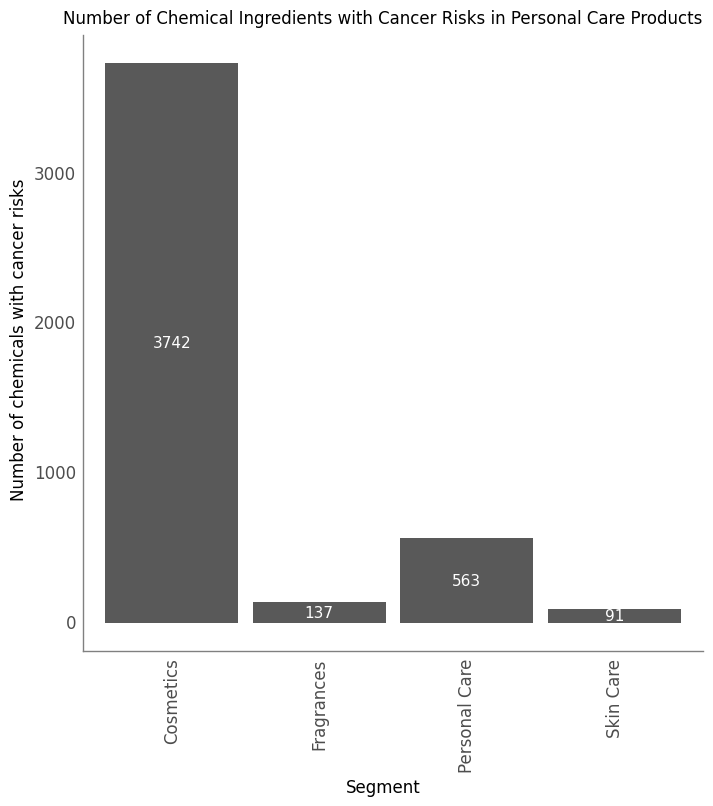

<ggplot: (8769711274725)>

In [69]:
#bar chart - # of reported ingredients with cancer risks per segment
plotnine.options.figure_size = (8, 8)

p= (
    ggplot(df_segment_chemicals_risks, aes(x='Segment', y='n_cancer', label='n_cancer')) # labels argument puts data labels on bars 
      + geom_bar(stat='identity') # arranges aes() maps into bar geometry
      + geom_text(position=position_stack(vjust=.5), color='white') # adjusts the positioning and color of the data labels
      + xlab("Segment") # adds x axis label
      + ylab("Number of chemicals with cancer risks") # adds y axis label
      + ggtitle("Number of Chemical Ingredients with Cancer Risks in Personal Care Products") # adds chart title
      + theme_classic() # predefined 'look and feel' format. theme_classic() is very simple. See for more: https://plotnine.readthedocs.io/en/stable/api.html#themes
      + theme(axis_text_x = element_text(angle = 90, vjust = 1, hjust=.5),
              axis_line=element_line(color="gray"), # further adjusts theme_classic() - axis line white 
              axis_ticks=element_line (color ="white"), # further adjusts theme_classic() - axis ticks white
              text=element_text(size = 12))
  ) 

p

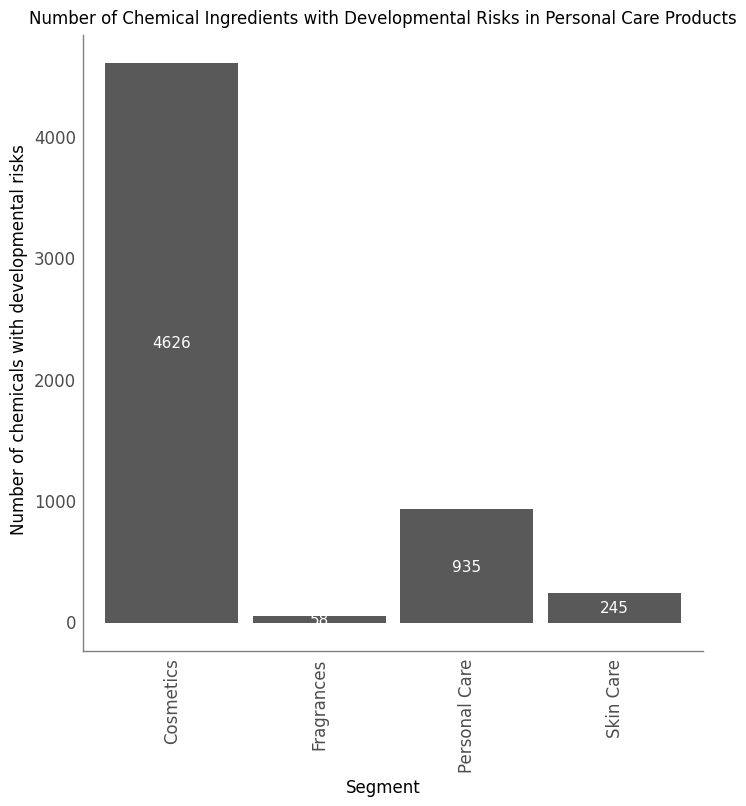

<ggplot: (8769711251137)>

In [70]:
#bar chart - # of reported ingredients with developmental risks per segment
plotnine.options.figure_size = (8, 8)

p= (
    ggplot(df_segment_chemicals_risks, aes(x='Segment', y='n_developmental', label='n_developmental')) # labels argument puts data labels on bars 
      + geom_bar(stat='identity') # arranges aes() maps into bar geometry
      + geom_text(position=position_stack(vjust=.5), color='white') # adjusts the positioning and color of the data labels
      + xlab("Segment") # adds x axis label
      + ylab("Number of chemicals with developmental risks") # adds y axis label
      + ggtitle("Number of Chemical Ingredients with Developmental Risks in Personal Care Products") # adds chart title
      + theme_classic() # predefined 'look and feel' format. theme_classic() is very simple. See for more: https://plotnine.readthedocs.io/en/stable/api.html#themes
      + theme(axis_text_x = element_text(angle = 90, vjust = 1, hjust=.5),
              axis_line=element_line(color="gray"), # further adjusts theme_classic() - axis line white 
              axis_ticks=element_line (color ="white"), # further adjusts theme_classic() - axis ticks white
              text=element_text(size = 12))
  ) 

p